In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [4]:
data = pd.read_csv("updated_resume_dataset.csv", encoding='utf-8')

In [5]:
data['cleaned_resume'] = ''
data.head()

,Category,Resume,cleaned_resume
0,Data Science,Skills * Programming Languages: Python (pandas...,
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",


In [7]:
print ("Displaying the distinct categories of resume -")
print (data['Category'].unique())

Displaying the distinct categories of resume -
['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']


In [8]:
print ("Displaying the distinct categories of resume and the number of records belonging to each category -")
print (data['Category'].value_counts())

Displaying the distinct categories of resume and the number of records belonging to each category -
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64


<Axes: xlabel='count', ylabel='Category'>

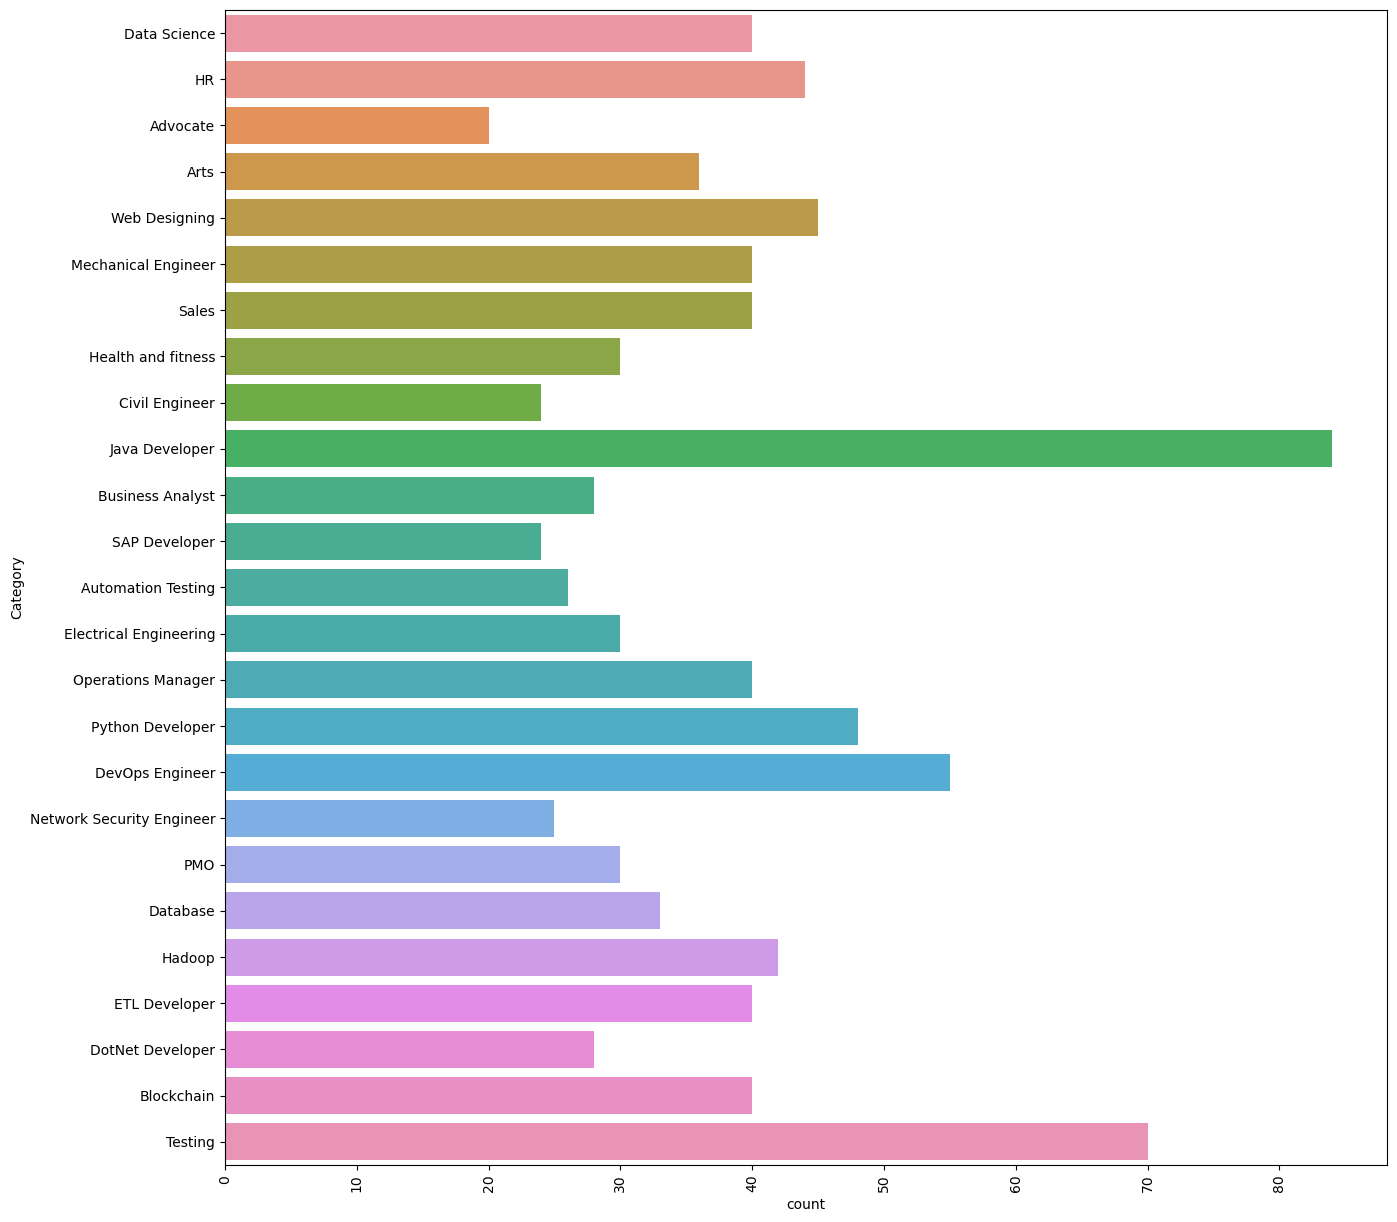

In [9]:
import seaborn as sns
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(y="Category", data=data)

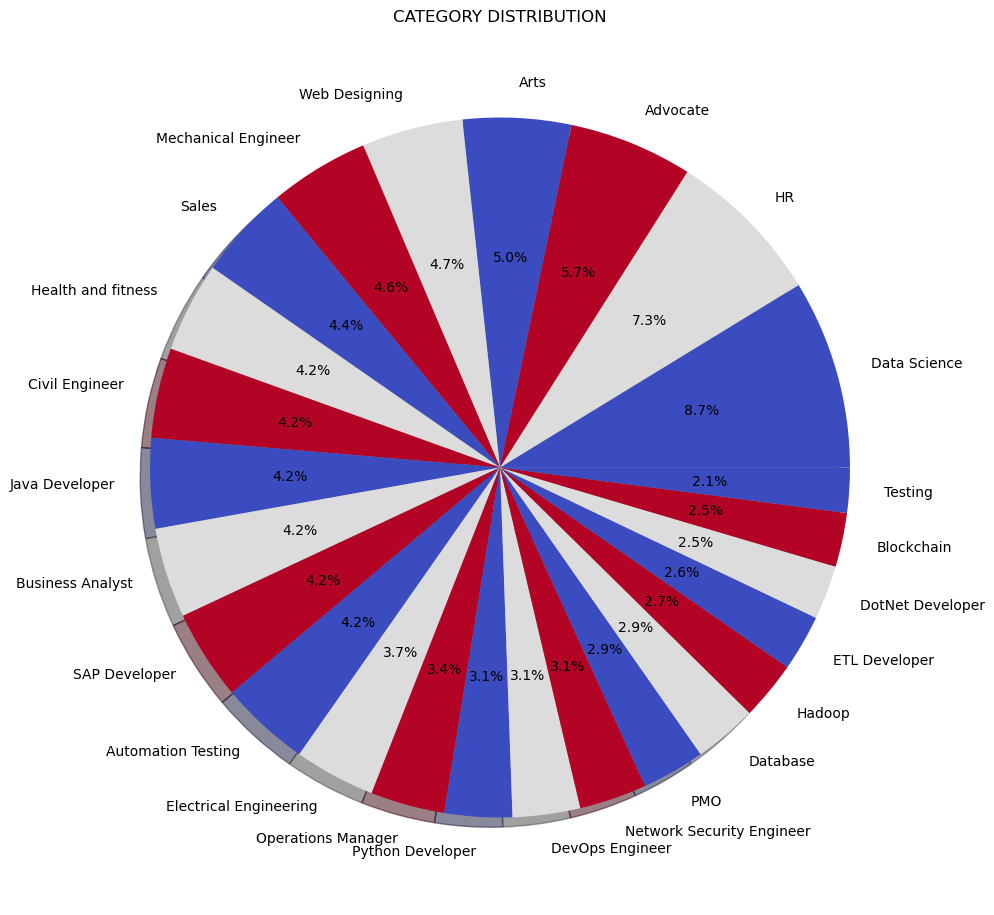

In [10]:
# visualize the distribution of categories
from matplotlib.gridspec import GridSpec
targetCounts = data['Category'].value_counts()
targetLabels  = data['Category'].unique()
# Make square figures and axes
plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('coolwarm')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()

In [12]:
#create a helper function to remove urls, hashtags, mentions and ounctuations
import re
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText
    
data['cleaned_resume'] = data.Resume.apply(lambda x: cleanResume(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ayomidealabi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ayomidealabi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('Details', 484), ('Exprience', 446), ('months', 376), ('company', 330), ('description', 310), ('1', 290), ('year', 232), ('January', 216), ('Less', 204), ('Data', 200), ('data', 192), ('Skill', 166), ('Maharashtra', 166), ('6', 164), ('Python', 156), ('Science', 154), ('I', 146), ('Education', 142), ('College', 140), ('The', 126), ('project', 126), ('like', 126), ('Project', 124), ('Learning', 116), ('India', 114), ('Machine', 112), ('University', 112), ('Web', 106), ('using', 104), ('monthsCompany', 102), ('B', 98), ('C', 98), ('SQL', 96), ('time', 92), ('learning', 90), ('Mumbai', 90), ('Pune', 90), ('Arts', 90), ('A', 84), ('application', 84), ('Engineering', 78), ('24', 76), ('various', 76), ('Software', 76), ('Responsibilities', 76), ('Nagpur', 76), ('development', 74), ('Management', 74), ('projects', 74), ('Technologies', 72)]


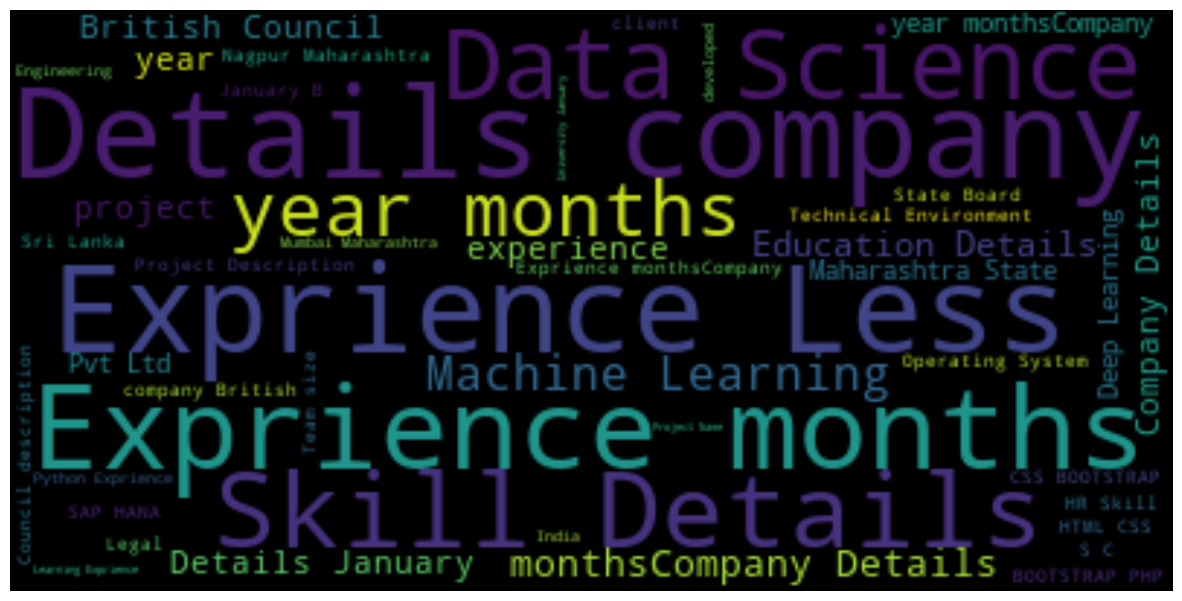

In [17]:
nltk.download('stopwords')
nltk.download('punkt')

oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords = []
Sentences = data['Resume'].values
cleanedSentences = ""

for i in range(0, 160):
    cleanedText = cleanResume(Sentences[i])
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)

wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

wc = WordCloud().generate(cleanedSentences)
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


In [20]:
# convert the words into categorical values
from sklearn.preprocessing import LabelEncoder

var_mod = ['Category']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [21]:
# train ML model for resume screening

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

requiredText = data['cleaned_resume'].values
requiredTarget = data['Category'].values

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=1500)
word_vectorizer.fit(requiredText)
WordFeatures = word_vectorizer.transform(requiredText)

print ("Feature completed .....")

X_train,X_test,y_train,y_test = train_test_split(WordFeatures,requiredTarget,random_state=0, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

Feature completed .....
(769, 1500)
(193, 1500)


In [22]:
clf = OneVsRestClassifier(KNeighborsClassifier())
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of KNeighbors Classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

print("\n Classification report for classifier %s:\n%s\n" % (clf, metrics.classification_report(y_test, prediction)))

Accuracy of KNeighbors Classifier on training set: 0.99
Accuracy of KNeighbors Classifier on test set: 0.99

 Classification report for classifier OneVsRestClassifier(estimator=KNeighborsClassifier()):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         6
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         7
           8       1.00      0.91      0.95        11
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00         8
          11       0.90      1.00      0.95         9
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.